In [3]:
import numpy as np
import os
import pandas as pd
import hdbscan
import optuna
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from hdbscan.validity import validity_index
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.cluster import AgglomerativeClustering

# Ignorar warnings
warnings.filterwarnings("ignore")
os.chdir('c:/Users/admin/OneDrive/Documents/TrabajoTesis') 

# 1. Load the file
file_path = 'NeoModelos/matrices_chile_complete.npz'  # Adjust filename if needed
data = np.load(file_path)

# 2. See what regions are inside
print("Available keys in the file:")
print(data.files) 

# 3. Inspect a specific region (e.g., 'III' - Atacama)
target_region = 'III'
matrix_key = f"{target_region}_matrix"
ids_key = f"{target_region}_ids"

if matrix_key in data:
    matrix = data[matrix_key]
    ids = data[ids_key]
    
    print(f"\n--- Region {target_region} Analysis ---")
    print(f"Matrix Shape: {matrix.shape} (Mines x Mines)")
    print(f"Number of Mines: {len(ids)}")
    
    # Show stats
    print(f"Min Travel Time: {np.min(matrix):.1f} mins")
    print(f"Avg Travel Time: {np.mean(matrix):.1f} mins")
    print(f"Max Travel Time: {np.max(matrix):.1f} mins")
    
    # Show a small corner of the matrix (5x5)
    print("\nSample Data (First 5x5):")
    print(matrix[:5, :5])
else:
    print(f"Region {target_region} not found in file.")

Available keys in the file:
['I_matrix', 'I_ids', 'II_matrix', 'II_ids', 'III_matrix', 'III_ids', 'IV_matrix', 'IV_ids', 'RM_matrix', 'RM_ids', 'V_matrix', 'V_ids', 'VI_matrix', 'VI_ids', 'VII_matrix', 'VII_ids', 'XV_matrix', 'XV_ids']

--- Region III Analysis ---
Matrix Shape: (2372, 2372) (Mines x Mines)
Number of Mines: 2372
Min Travel Time: 0.0 mins
Avg Travel Time: 197.5 mins
Max Travel Time: 897.1 mins

Sample Data (First 5x5):
[[0.00000000e+00 2.57298340e+02 2.58334991e+02 2.58551666e+02
  2.57570007e+02]
 [2.58826660e+02 0.00000000e+00 1.03016663e+01 1.05183325e+01
  9.53666687e+00]
 [2.54848343e+02 1.00216665e+01 0.00000000e+00 2.16666669e-01
  7.25000024e-01]
 [2.55118332e+02 1.02916670e+01 2.70000011e-01 0.00000000e+00
  9.95000005e-01]
 [2.54188324e+02 9.49166679e+00 7.65000045e-01 9.81666684e-01
  0.00000000e+00]]


In [4]:
import pandas as pd
import numpy as np
import hdbscan
import plotly.express as px
import os

# ==========================================
# CONFIGURATION
# ==========================================
MATRIX_FILE = 'NeoModelos/matrices_chile_complete.npz'
DATA_FILE = 'NeoModelos/minas_ll.csv'
OUTPUT_HTML = 'NeoModelos/mapa_chile_debug.html'

def clean_id(value):
    """Forces any ID to a clean string '123' format (removes .0 decimals)"""
    try:
        return str(int(float(value)))
    except:
        return str(value).strip()

if __name__ == "__main__":
    print("--- 🕵️‍♂️ Starting Deep Diagnostic ---")
    
    # 1. Load Data
    if not os.path.exists(MATRIX_FILE) or not os.path.exists(DATA_FILE):
        print("❌ Error: Files not found.")
        exit()
        
    df = pd.read_csv(DATA_FILE)
    
    # Ensure Lat/Lon are floats
    df['Latitud'] = pd.to_numeric(df['Latitud'], errors='coerce')
    df['Longitud'] = pd.to_numeric(df['Longitud'], errors='coerce')
    df = df.dropna(subset=['Latitud', 'Longitud'])
    
    # CLEAN IDs IN DATAFRAME
    if 'IdFaena' in df.columns:
        print(f"   Raw CSV ID Example: {df['IdFaena'].iloc[0]}")
        df['IdFaena_Clean'] = df['IdFaena'].apply(clean_id)
        print(f"   Clean CSV ID Example: {df['IdFaena_Clean'].iloc[0]}")
    else:
        print("❌ Error: 'IdFaena' column missing from CSV.")
        exit()

    data = np.load(MATRIX_FILE)
    df['Cluster_ID'] = "Unassigned"
    
    regions = set([k.split('_')[0] for k in data.files if '_matrix' in k])
    print(f"\n🔄 Processing {len(regions)} regions...")
    
    total_matches = 0

    for region in regions:
        matrix_key = f"{region}_matrix"
        ids_key = f"{region}_ids"
        
        if matrix_key not in data: continue
            
        # Load and Clean Matrix IDs
        matrix = data[matrix_key].astype(np.float64)
        raw_ids = data[ids_key]
        
        # Clean IDs from NPZ file
        clean_ids_npz = [clean_id(x) for x in raw_ids]
        
        # Debug first region only
        if total_matches == 0:
            print(f"   [Debug Region {region}] Matrix IDs Example: {clean_ids_npz[0]}")
        
        # Run Clustering
        clusterer = hdbscan.HDBSCAN(
            metric='precomputed',
            min_cluster_size=5,
            min_samples=3
        )
        clusterer.fit(matrix)
        labels = clusterer.labels_
        
        # Create dictionary {CleanID: ClusterLabel}
        region_mapping = {}
        for i, mine_id in enumerate(clean_ids_npz):
            label = labels[i]
            if label == -1:
                region_mapping[mine_id] = "Ruido"
            else:
                region_mapping[mine_id] = f"{region}_{label}"
                
        # Apply mapping
        # We match 'IdFaena_Clean' (CSV) with the keys of region_mapping (NPZ)
        matches = df[df['IdFaena_Clean'].isin(region_mapping.keys())]
        
        if len(matches) > 0:
            # Update the main dataframe
            # This technique maps the dictionary to the clean ID column
            df.loc[matches.index, 'Cluster_ID'] = df.loc[matches.index, 'IdFaena_Clean'].map(region_mapping)
            total_matches += len(matches)
        else:
            print(f"   ⚠️ Warning: Region {region} calculated but ZERO matches found in CSV. ID mismatch?")

    # ==========================================
    # REPORT & PLOT
    # ==========================================
    print(f"\n📊 Final Report:")
    print(f"   Total Mines in CSV: {len(df)}")
    print(f"   Total Mines Clustered: {total_matches}")
    
    if total_matches == 0:
        print("❌ CRITICAL: No IDs matched. The map will be blank.")
        print("   Check: Do the IDs in 'minas_ll.csv' match the ones used to create the matrix?")
        exit()

    # Filter for map
    plot_data = df[df['Cluster_ID'] != "Unassigned"].copy()
    plot_data = plot_data.sort_values('Cluster_ID')

    print(f"   Generating map with {len(plot_data)} points...")

    fig = px.scatter_mapbox(
        plot_data,
        lat="Latitud",
        lon="Longitud",
        color="Cluster_ID",
        hover_name="Cluster_ID",
        hover_data=["RegionFaena", "IdFaena"],
        zoom=5,
        height=900,
        title=f"Chile Mining Clusters (Diagnostic Run - {total_matches} points)",
        color_discrete_map={"Ruido": "gray"}
    )

    # Use basic style to ensure it renders
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    
    # Auto-center the map
    fig.update_layout(mapbox_bounds={"west": -75, "east": -65, "south": -56, "north": -17})
    fig.update_layout(mapbox_center={"lat": -28, "lon": -70})

    fig.write_html(OUTPUT_HTML)
    print(f"✅ Map saved to: {OUTPUT_HTML}")

--- 🕵️‍♂️ Starting Deep Diagnostic ---
   Raw CSV ID Example: 153576
   Clean CSV ID Example: 153576

🔄 Processing 9 regions...
   [Debug Region III] Matrix IDs Example: 153576

📊 Final Report:
   Total Mines in CSV: 7930
   Total Mines Clustered: 7930
   Generating map with 7930 points...
✅ Map saved to: NeoModelos/mapa_chile_debug.html


--- 📊 Generating Static Cluster Diagram ---
🔄 Calculating clusters for 9 regions...
✅ Clustered 7930 mines.
🎨 Drawing plot...
✅ Diagram saved to: NeoModelos/diagrama_clusters_chile.png


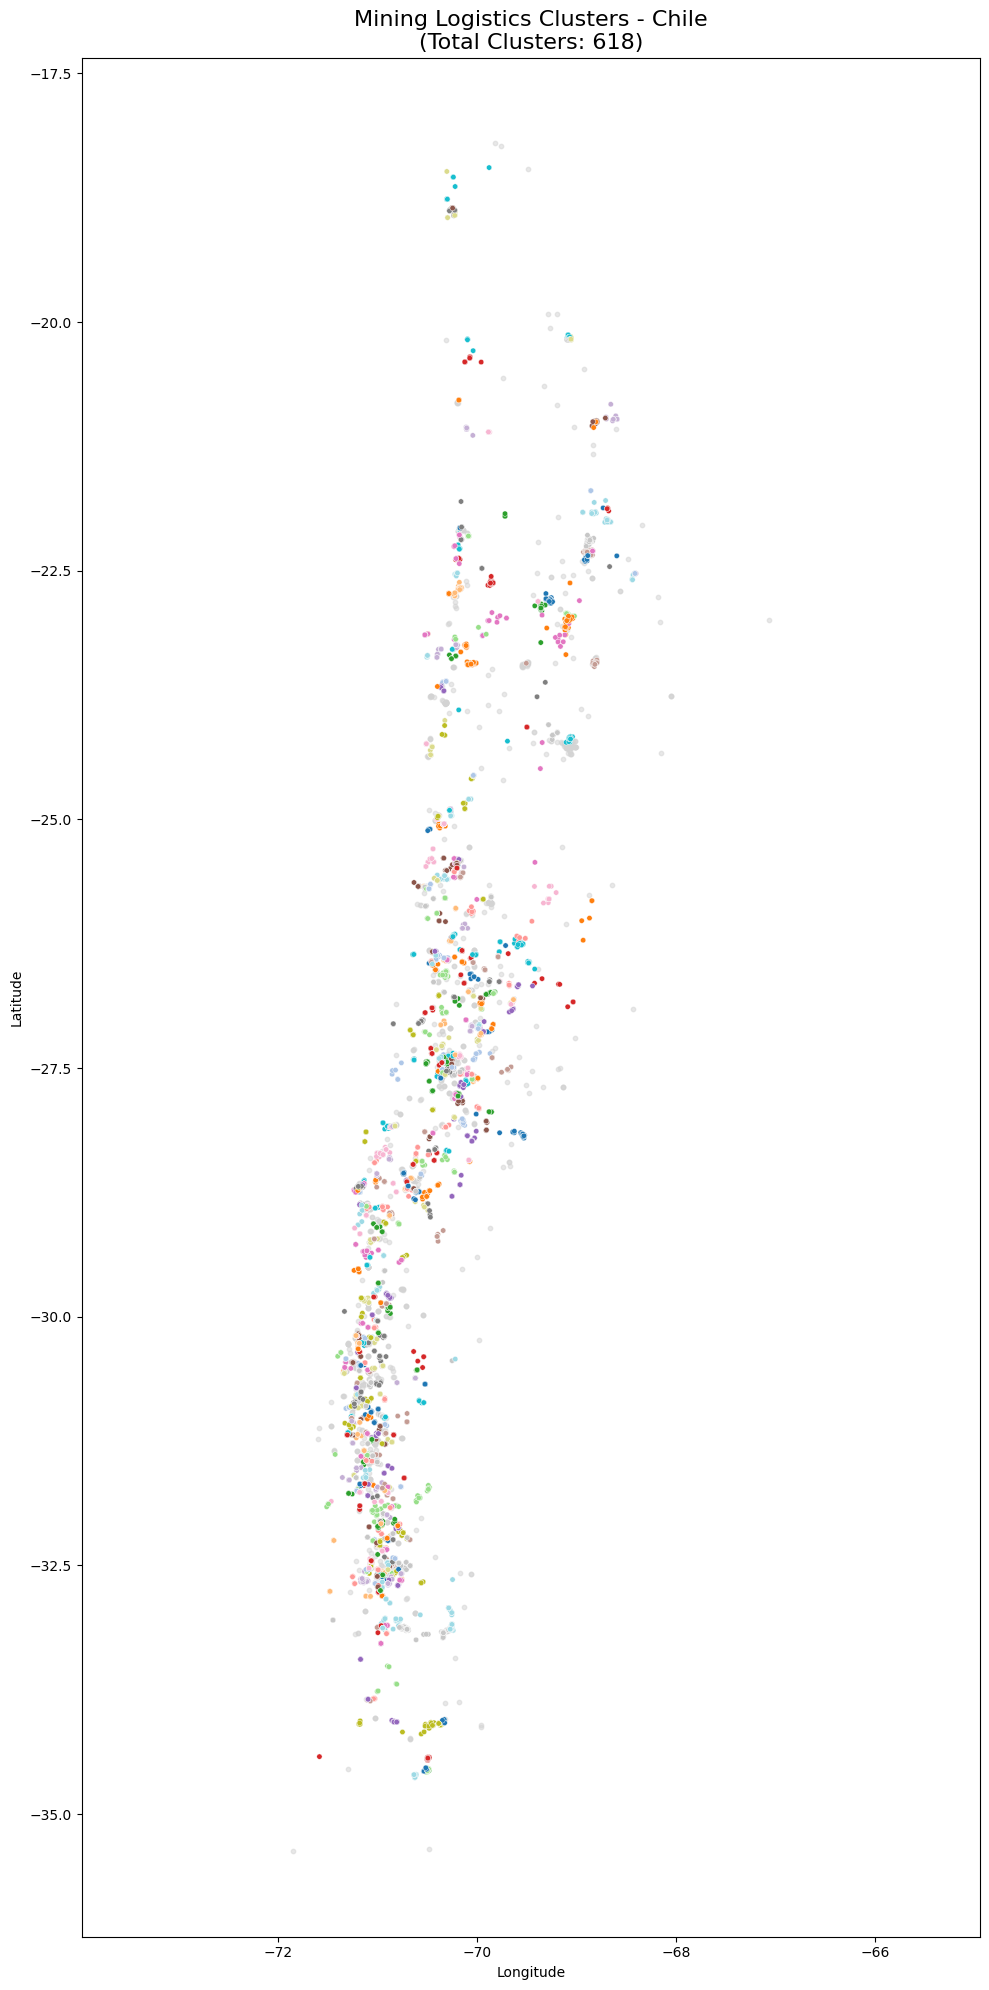

In [5]:
import pandas as pd
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# CONFIGURATION
# ==========================================
MATRIX_FILE = 'NeoModelos/matrices_chile_complete.npz'
DATA_FILE = 'NeoModelos/minas_ll.csv'
OUTPUT_IMAGE = 'NeoModelos/diagrama_clusters_chile.png'

# Model Settings
MIN_CLUSTER_SIZE = 5
MIN_SAMPLES = 3

if __name__ == "__main__":
    print("--- 📊 Generating Static Cluster Diagram ---")
    
    # 1. Load Data
    if not os.path.exists(MATRIX_FILE) or not os.path.exists(DATA_FILE):
        print("❌ Error: Files not found.")
        exit()

    df = pd.read_csv(DATA_FILE)
    
    # CRITICAL FIX: Force IDs to string for matching
    if 'IdFaena' in df.columns:
        df['IdFaena'] = df['IdFaena'].astype(str)
        
    data = np.load(MATRIX_FILE)
    df['Cluster_ID'] = "Not Processed"
    
    # 2. Process Regions
    regions = set([k.split('_')[0] for k in data.files if '_matrix' in k])
    print(f"🔄 Calculating clusters for {len(regions)} regions...")
    
    total_points = 0
    
    for region in regions:
        matrix_key = f"{region}_matrix"
        ids_key = f"{region}_ids"
        
        if matrix_key not in data: continue
        
        # Load matrix as float64 (Fix for buffer mismatch)
        matrix = data[matrix_key].astype(np.float64)
        ids = data[ids_key].astype(str) # Force IDs to string
        
        # Run Clustering
        clusterer = hdbscan.HDBSCAN(
            metric='precomputed',
            min_cluster_size=MIN_CLUSTER_SIZE,
            min_samples=MIN_SAMPLES,
            cluster_selection_method='eom'
        )
        clusterer.fit(matrix)
        labels = clusterer.labels_
        
        # Generate Labels
        unique_labels = []
        for l in labels:
            if l == -1:
                unique_labels.append("Ruido")
            else:
                unique_labels.append(f"{region}_{l}") # e.g., "III_5"
        
        # Map to DataFrame
        if 'IdFaena' in df.columns:
            label_map = dict(zip(ids, unique_labels))
            mask = df['IdFaena'].isin(ids)
            df.loc[mask, 'Cluster_ID'] = df.loc[mask, 'IdFaena'].map(label_map)
            total_points += mask.sum()
            
    print(f"✅ Clustered {total_points} mines.")

    # ==========================================
    # 3. PLOT DIAGRAM
    # ==========================================
    print("🎨 Drawing plot...")
    
    # Filter data
    plot_data = df[df['Cluster_ID'] != "Not Processed"].copy()
    
    # Separate Noise vs Clusters for better coloring
    noise_data = plot_data[plot_data['Cluster_ID'] == 'Ruido']
    cluster_data = plot_data[plot_data['Cluster_ID'] != 'Ruido']
    
    # Set up the figure (Tall and narrow for Chile)
    plt.figure(figsize=(10, 20))
    
    # 1. Plot Noise (Gray background points)
    plt.scatter(
        noise_data['Longitud'], 
        noise_data['Latitud'], 
        c='lightgray', 
        s=10, 
        alpha=0.5, 
        label='Ruido (Noise)'
    )
    
    # 2. Plot Clusters (Colored)
    # We use seaborn to handle the categorical colors easily
    sns.scatterplot(
        data=cluster_data,
        x='Longitud',
        y='Latitud',
        hue='Cluster_ID',
        palette='tab20', # A palette with many distinct colors
        s=15,            # Dot size
        legend=False     # Hide legend (too many clusters to list)
    )
    
    # Formatting
    plt.title(f"Mining Logistics Clusters - Chile\n(Total Clusters: {len(cluster_data['Cluster_ID'].unique())})", fontsize=16)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis('equal') # Keeps Chile's shape correct (not stretched)
    
    # Save
    plt.tight_layout()
    plt.savefig(OUTPUT_IMAGE, dpi=300)
    print(f"✅ Diagram saved to: {OUTPUT_IMAGE}")
    plt.show()